In [16]:
#Imports
import numpy as np
import pylab
import pickle
from scipy.interpolate import interp1d
%matplotlib inline

In [17]:
#Set up the binning to our tastes
BinsCosTheta=np.linspace(-1,1,30)
BinsE=np.arange(0.6,1.42,0.02)

BinCentersE=(BinsE[1:]+BinsE[:-1])/2
BinCentersCosTheta=(BinsCosTheta[1:]+BinsCosTheta[:-1])/2

CosThetaMesh,EMesh=np.meshgrid(BinCentersCosTheta, BinCentersE, sparse=False, indexing='ij')
EMesh=np.ndarray.flatten(EMesh)
CosThetaMesh=np.ndarray.flatten(CosThetaMesh)


In [18]:
#These are toy spectra, we don't use them.
def ExampleBackgroundSpectrum(E, costheta):
    return 1./(E+0.1)
    
def ExampleSignalSpectrum(E, costheta):
    return (E<2.)*(np.exp(-costheta**2/0.1**2)) 

In [19]:
#Make Signal Hypothesis Template

#Loaded from EFMs code
FluxFile=open("../CNO-Neutrino-Code/FluxFunction.pkl","rb")
FluxFunction=pickle.load(FluxFile)
FluxFile.close()

def NeutrinoEnergySpectrum(E):
    return FluxFunction(E)

#Diff cross section from Giunti and Kim
def dsig_dEdcth(E, cth):
    me=0.511
    g1=0.73
    g2=0.23
    return (cth>0)*(4*E**2*(me+E)**2*cth/((me+E)**2-E**2*cth**2)**2 * (g1**2+g2**2*(1-(2*me*E*cth**2)/((me+E)**2-E**2*cth**2))**2-2*g1*g2*me**2*cth**2/((me+E)**2-E**2*cth**2) ))

#Spectrum is cross section multiplied by flux
def ExampleSignalSpectrum(E,cth):
    return NeutrinoEnergySpectrum(E)*dsig_dEdcth(E,cth)

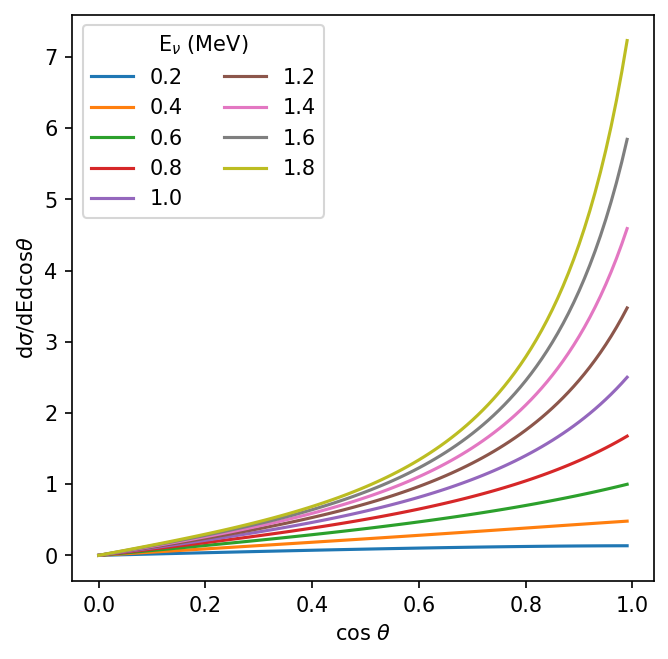

In [20]:
#Take a look at the cross section

pylab.figure(figsize=(5,5),dpi=150)
vars=np.arange(0,1,0.01)
for E in np.arange(0.2,2,0.2):
    pylab.plot(vars,dsig_dEdcth(E,vars),label=round(E,2))
pylab.xlabel(r"cos $\theta$")
pylab.ylabel(r"d$\sigma$/dEdcos$\theta$")
pylab.legend(loc='upper left',title=r'E$_\nu$ (MeV)',ncol=2)

In [21]:
#Form Background Hypothesis Template (output of EFC's code)

BackgroundDist=np.array(np.load("../k40_gas_Edep.npy",allow_pickle=True),ndmin=1)
BGCounts=BackgroundDist[0]['counts']
BGBins=BackgroundDist[0]['binedges']
BGNorm=BackgroundDist[0]['norm']

EDistBG=[]
for i in BinsE:
    EDistBG.append(BGCounts[np.abs(BGBins[:-1]-i)<1e-3][0])
BGShape=interp1d(BGBins[1:]-(BGBins[1]-BGBins[0])/2,BGCounts,kind='linear')

def ExampleBackgroundSpectrum(E,cth):
    return BGShape(E)

In [22]:
#Make binned versions

SignalSpectrum=np.ndarray(shape=(len(BinsCosTheta)-1,len(BinsE)-1))
BackgroundSpectrum=np.ndarray(shape=(len(BinsCosTheta)-1,len(BinsE)-1))

for i in range(0,len(BinsCosTheta)-1):
    for j in range(0,len(BinsE)-1):
        SignalSpectrum[i,j]=ExampleSignalSpectrum(BinCentersE[j], BinCentersCosTheta[i])
        BackgroundSpectrum[i,j]=ExampleBackgroundSpectrum(BinCentersE[j], BinCentersCosTheta[i])
        
SignalSpectrum/=sum(SignalSpectrum.flatten())
BackgroundSpectrum/=sum(BackgroundSpectrum.flatten())

In [23]:
#This is our fit function that takes input weights a and b for the 
# two components.

def TemplateToFit(a,b):
    return a*SignalSpectrum+b*BackgroundSpectrum

#These project the 2D histograms down to 1D ones
def GetCosThProj(hist):
    return [sum(i) for i in hist]

def GetEProj(hist):
    return [sum(i) for i in hist.T]

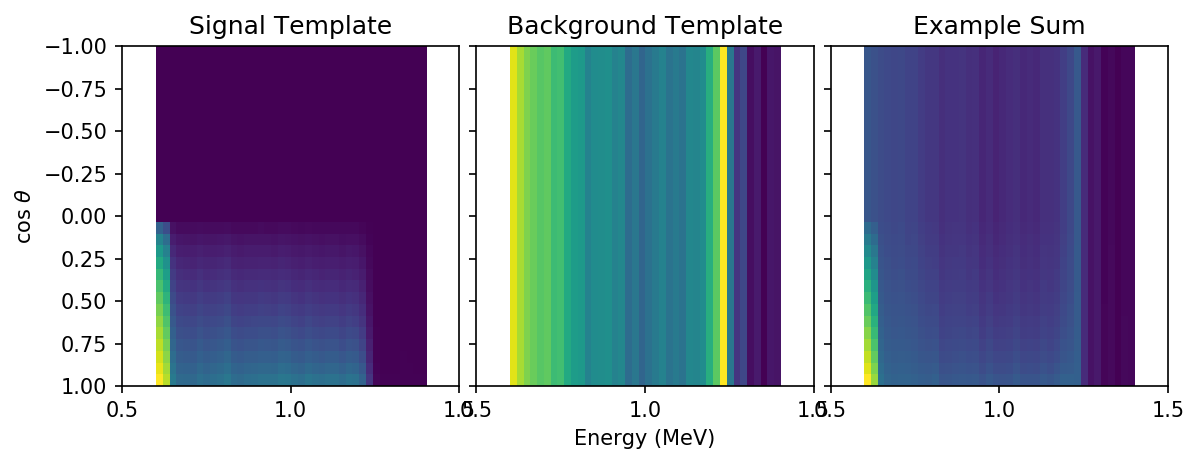

In [24]:
#Lets take a look at our 2D templates

fig, (ax1, ax2, ax3)=pylab.subplots(1,3,figsize=(9,3),dpi=150,sharey=True)
fig.subplots_adjust(wspace=0.05)

ax1.imshow(np.log(TemplateToFit(1,0)+1e-3),extent=[BinsE[0],BinsE[-1],BinsCosTheta[-1],BinsCosTheta[0]],aspect='auto')
ax1.set_title('Signal Template')
ax2.imshow(np.log(TemplateToFit(0,1)+1e-3),extent=[BinsE[0],BinsE[-1],BinsCosTheta[-1],BinsCosTheta[0]],aspect='auto')
ax2.set_title('Background Template')
ax3.imshow(np.log(TemplateToFit(1,10)+1e-3),extent=[BinsE[0],BinsE[-1],BinsCosTheta[-1],BinsCosTheta[0]],aspect='auto')
ax3.set_title('Example Sum')
ax2.set_xlabel("Energy (MeV)")
ax1.set_ylabel(r"cos $\theta$")
ax1.set_xticks([0.5,1.0,1.5])
ax2.set_xticks([0.5,1.0,1.5])
ax3.set_xticks([0.5,1.0,1.5])
pylab.show()

In [25]:
#This draws a pseudoexperiment event-by-event. We don't use it because it is a slow approach.

def SampleFromDist(Dist,Count):
    hist, x_bins, y_bins = np.histogram2d( CosThetaMesh,EMesh, bins=(BinsCosTheta+0.01, BinsE+0.01),weights=Dist(EMesh,CosThetaMesh))
    x_bin_midpoints = x_bins[:-1] + np.diff(x_bins)/2
    y_bin_midpoints = y_bins[:-1] + np.diff(y_bins)/2
    cdf = np.cumsum(hist.ravel())
    cdf = cdf / cdf[-1]

    values = np.random.rand(Count)
    value_bins = np.searchsorted(cdf, values)
    x_idx, y_idx = np.unravel_index(value_bins,
                                (len(x_bin_midpoints),
                                 len(y_bin_midpoints)))
    random_from_cdf = np.column_stack((x_bin_midpoints[x_idx],
                                   y_bin_midpoints[y_idx]))
    new_x, new_y = random_from_cdf.T
    return new_x, new_y

In [26]:
#This does poisson sampling to generate a psedoexperiment histogram. We use it because it is fast

def PoissonFromDist(Dist,Count):
    hist, x_bins, y_bins = np.histogram2d( CosThetaMesh,EMesh, bins=(BinsCosTheta, BinsE),weights=Dist(EMesh,CosThetaMesh))
    hist=hist*Count/sum(sum(hist))
    samplehist=[]
    for i in range(0, len(x_bins)-1):
        samplehistrow=[]
        for j in range(0, len(y_bins)-1):
            samplehistrow.append(np.random.poisson(hist[i][j])) 
        samplehist.append(samplehistrow)
        
    return np.array(samplehist)

In [27]:
#Make a sample realization with 2000 signal events and 100000 background ones

SigSampleHist=PoissonFromDist(ExampleSignalSpectrum, 2000)
BgSampleHist=PoissonFromDist(ExampleBackgroundSpectrum, 100000)

SampleHist=SigSampleHist+BgSampleHist

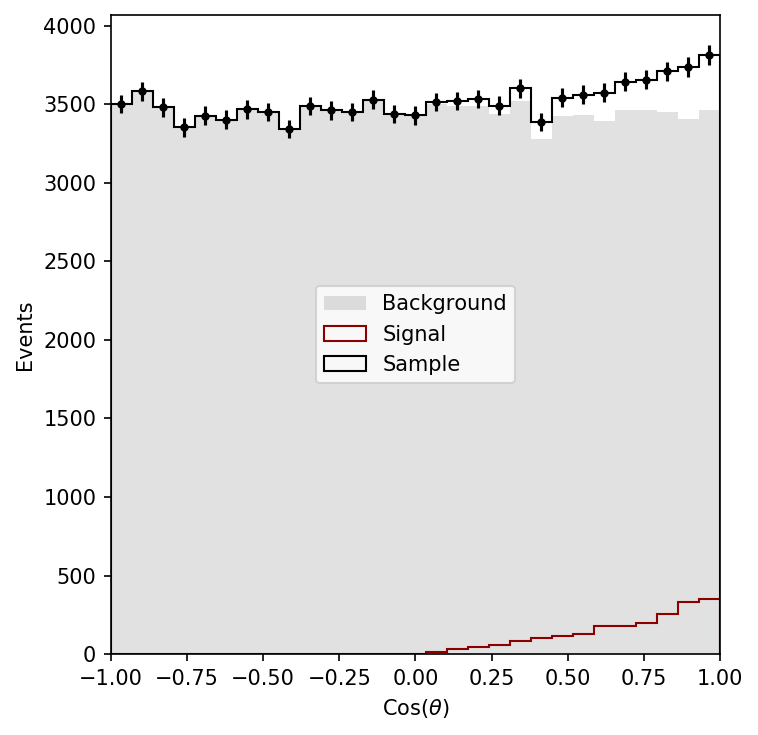

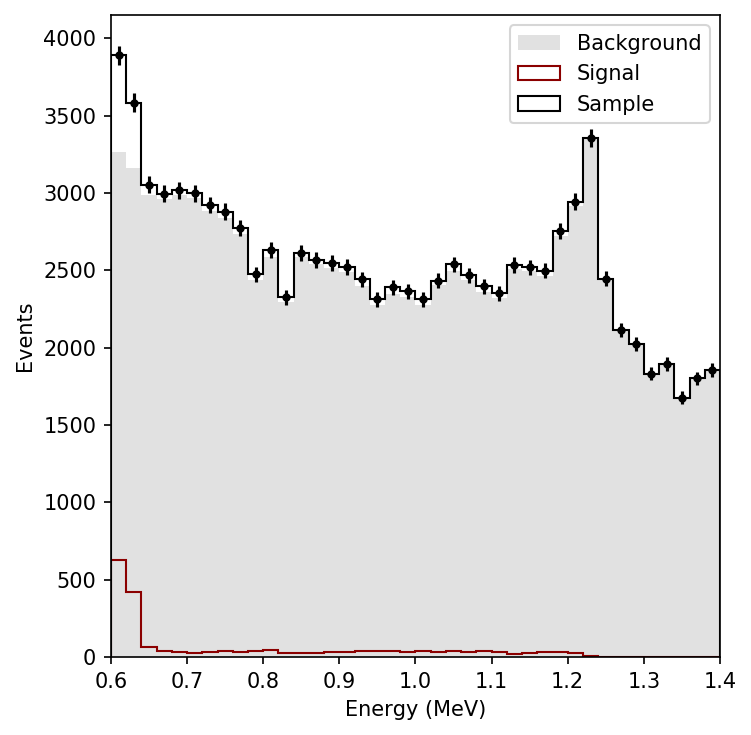

In [28]:
#Take a look at the projective plots

pylab.figure(figsize=(5,5),dpi=150)
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(BgSampleHist),bins=BinsCosTheta,label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(SigSampleHist),bins=BinsCosTheta,label='Signal',color='DarkRed',histtype='step')
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(SampleHist),bins=BinsCosTheta,label='Sample',color='black',histtype='step')
pylab.errorbar(BinCentersCosTheta,GetCosThProj(SampleHist),yerr=np.sqrt(GetCosThProj(SampleHist)),fmt='.',color='black')
pylab.xlabel(r"Cos($\theta$)")
pylab.legend(loc='center')
pylab.ylabel("Events")
pylab.tight_layout()
pylab.xlim(-1,1)
pylab.show()

pylab.figure(figsize=(5,5),dpi=150)
pylab.hist(BinCentersE,weights=GetEProj(BgSampleHist),bins=BinsE,label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersE,weights=GetEProj(SigSampleHist),bins=BinsE,label='Signal',color='DarkRed',histtype='step')
pylab.hist(BinCentersE,weights=GetEProj(SampleHist),bins=BinsE,label='Sample',color='black',histtype='step')
pylab.errorbar(BinCentersE,GetEProj(SampleHist),yerr=np.sqrt(GetEProj(SampleHist)),fmt='.',color='black')
pylab.xlabel(r"Energy (MeV)")
pylab.legend(loc='upper right')
pylab.ylabel("Events")
pylab.tight_layout()
pylab.xlim(BinsE[0],BinsE[-1])
pylab.show()

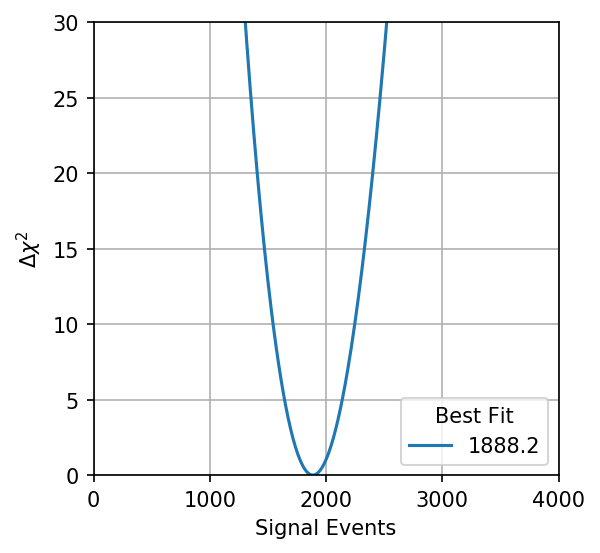

In [29]:
# Calculate a chi2 for the signal strength based on random pseudoexperiment

pylab.figure(figsize=(4,4),dpi=150)
Chi2=[]
arange=np.arange(0,1,0.0001)
TotalEvents=sum(SampleHist.flatten())
for a in arange:
    TrialFunction=TemplateToFit(a*TotalEvents,(1.-a)*TotalEvents)
    Chi2.append(sum(((TrialFunction-SampleHist)**2/TrialFunction).flatten()))
BestA=arange[np.argmin(Chi2)]
BestDist=TemplateToFit(BestA*TotalEvents,(1.-BestA)*TotalEvents)

pylab.plot(arange*TotalEvents,Chi2-min(Chi2),label=str(round(BestA*TotalEvents,1)))
pylab.legend(loc='lower right',title='Best Fit')
pylab.ylim(0,30)
pylab.xlim(0,4000)
pylab.xlabel("Signal Events")
pylab.ylabel(r"$\Delta \chi^2$")
pylab.grid()
pylab.show()

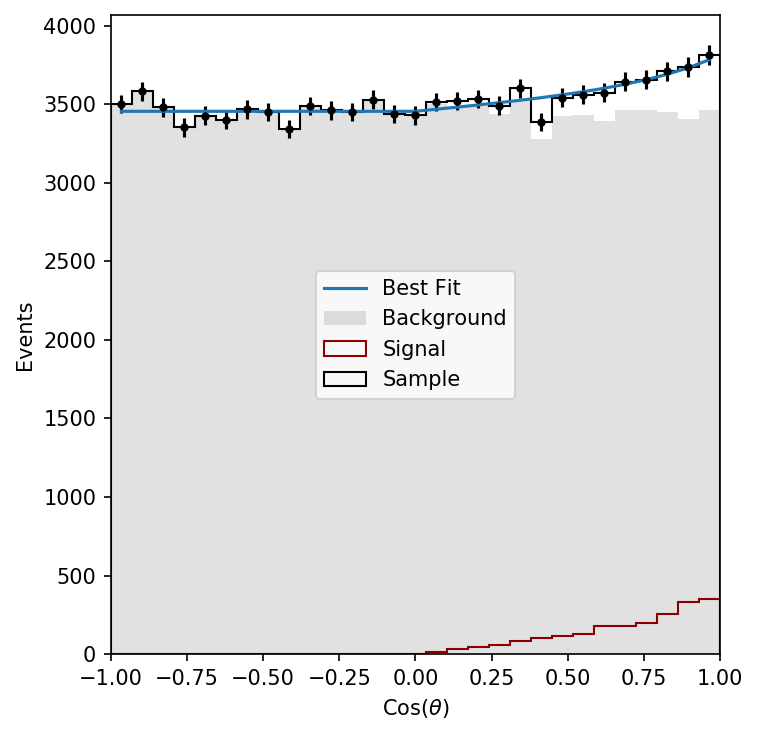

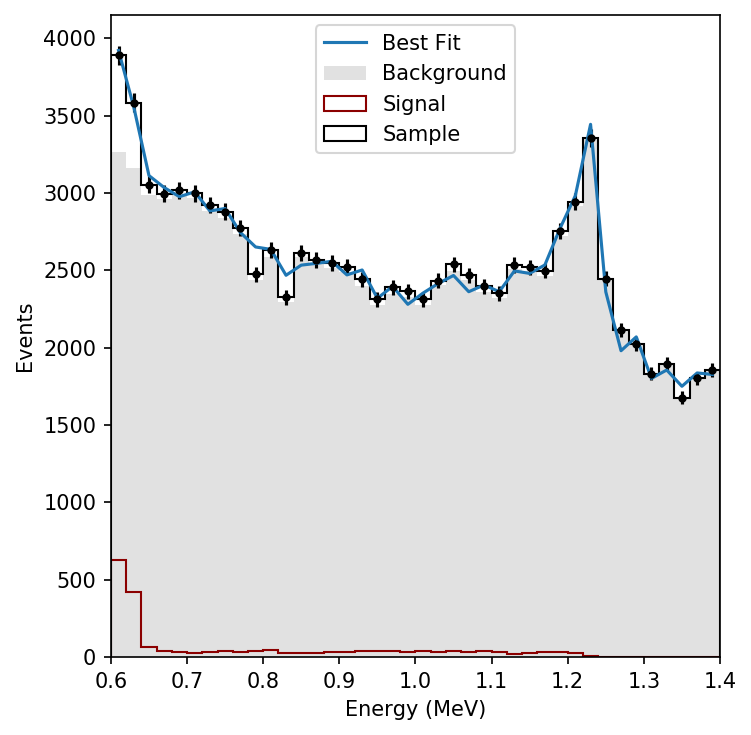

In [37]:


pylab.figure(figsize=(5,5),dpi=150)
#pylab.plot(BinCentersE,GetEProj(SampleHist),label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(BgSampleHist),bins=BinsCosTheta,label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(SigSampleHist),bins=BinsCosTheta,label='Signal',color='DarkRed',histtype='step')
pylab.hist(BinCentersCosTheta,weights=GetCosThProj(SampleHist),bins=BinsCosTheta,label='Sample',color='black',histtype='step')
pylab.errorbar(BinCentersCosTheta,GetCosThProj(SampleHist),yerr=np.sqrt(GetCosThProj(SampleHist)),fmt='.',color='black')
ThSpectrum=[sum(row) for row in BestDist]
pylab.plot(BinCentersCosTheta,ThSpectrum,label='Best Fit')
pylab.xlabel(r"Cos($\theta$)")
pylab.legend(loc='center')
pylab.ylabel("Events")
pylab.tight_layout()
pylab.xlim(-1,1)
pylab.show()

pylab.figure(figsize=(5,5),dpi=150)
#pylab.plot(BinCentersE,GetEProj(SampleHist),label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersE,weights=GetEProj(BgSampleHist),bins=BinsE,label='Background',color='dimgrey',alpha=0.2)
pylab.hist(BinCentersE,weights=GetEProj(SigSampleHist),bins=BinsE,label='Signal',color='DarkRed',histtype='step')
pylab.hist(BinCentersE,weights=GetEProj(SampleHist),bins=BinsE,label='Sample',color='black',histtype='step')
pylab.errorbar(BinCentersE,GetEProj(SampleHist),yerr=np.sqrt(GetEProj(SampleHist)),fmt='.',color='black')
ESpectrum=[sum(row) for row in BestDist.T]
pylab.plot(BinCentersE,ESpectrum,label='Best Fit')
pylab.xlabel(r"Energy (MeV)")
pylab.legend(loc='upper center')
pylab.ylabel("Events")
pylab.tight_layout()
pylab.xlim(BinsE[0],BinsE[-1])
pylab.show()


In [31]:
#Calculate the sensitivity
def GetSensitivity(SignalSizes,BackgroundSize,HowManyTimes):
    TimesPassed=[]
    for SignalSize in SignalSizes:
        DeltaChi2s=[]
        for i in range(0,HowManyTimes):
            SigSampleHist=PoissonFromDist(ExampleSignalSpectrum, SignalSize)
            BgSampleHist=PoissonFromDist(ExampleBackgroundSpectrum, BackgroundSize)

            SampleHist=SigSampleHist+BgSampleHist

            Chi2=[]
            arange=np.linspace(0,0.2,100)
            TotalEvents=sum(SampleHist.flatten())
            for a in arange:
                TrialFunction=TemplateToFit(a*TotalEvents,(1.-a)*TotalEvents)
                Chi2.append(sum(((TrialFunction-SampleHist)**2/TrialFunction).flatten()))
            DeltaChi2s.append(Chi2[0]-min(Chi2))
        DeltaChi2s=np.array(DeltaChi2s)
        TimesPassed.append(sum(DeltaChi2s<2.71))
       # print(SignalSize, BackgroundSize,TimesPassed)
        if TimesPassed[-1]<HowManyTimes/2.:
            SensFunc=interp1d(TimesPassed,SignalSizes[0:len(TimesPassed)])
            SensThisBG=SensFunc(HowManyTimes/2.)
            return SensThisBG
    return -1

In [32]:
#Scan sensitivities to solar neutrinos vs background
Sensitivities=[]
Backgrounds = np.logspace(4,8,5)
SignalSizes=np.logspace(1,6,20)

for b in Backgrounds:
    print("Calculating for b = "+str(b))
    Sensitivities.append(GetSensitivity(SignalSizes,
                        BackgroundSize=b,
                        HowManyTimes=100))
    SignalSizes=SignalSizes[SignalSizes>Sensitivities[-1]]

    print(Sensitivities[-1])

Calculating for b = 10000.0
53.26446919629417
Calculating for b = 100000.0
159.8987986399739
Calculating for b = 1000000.0
1081.2475891946092
Calculating for b = 10000000.0
11083.034650875608
Calculating for b = 100000000.0
88381.08640087435


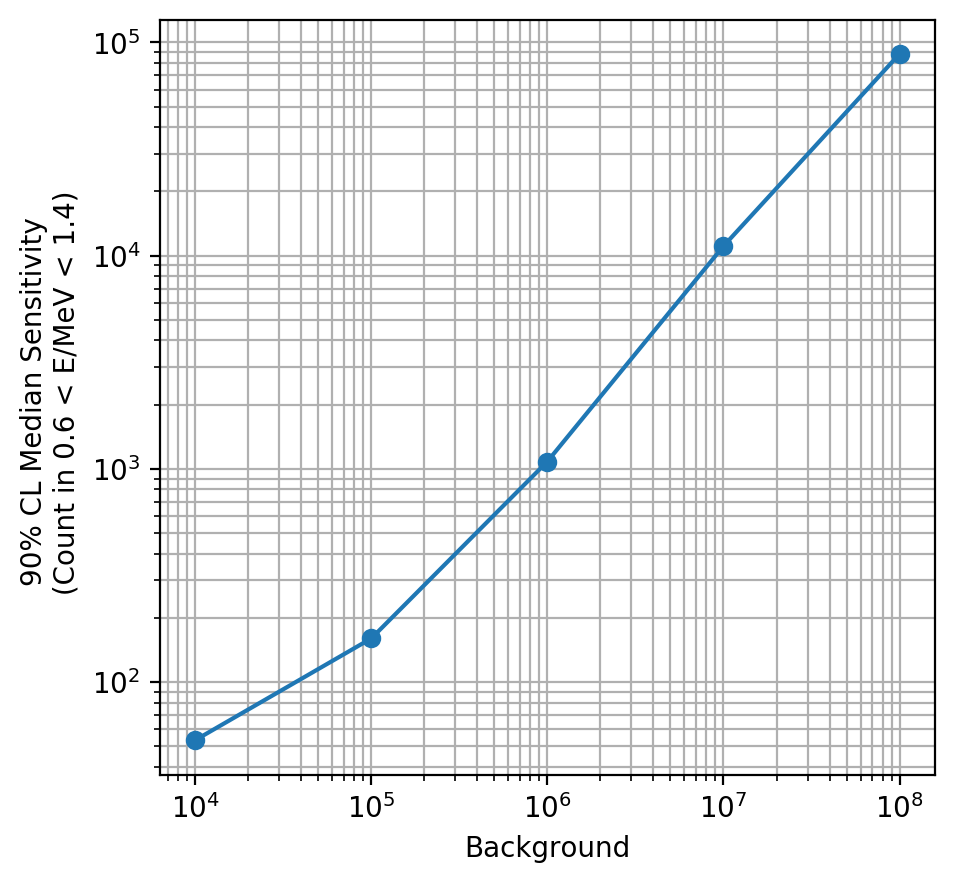

In [36]:
# Plot it
pylab.figure(figsize=(5,5),dpi=200)
pylab.loglog(Backgrounds, Sensitivities,'o-')
pylab.xlabel("Background")
pylab.ylabel("90% CL Median Sensitivity \n (Count in 0.6 < E/MeV < 1.4)")
pylab.grid(which='both')


In [34]:
# Load CNO-less flux

FluxFileNoCNO=open("../CNO-Neutrino-Code/FluxFunctionNoCNO.pkl","rb")
FluxFunctionNoCNO=pickle.load(FluxFileNoCNO)
FluxFileNoCNO.close()

def NeutrinoEnergySpectrumNoCNO(E):
    return FluxFunctionNoCNO(E)

def ExampleSignalSpectrumNoCNO(E,cth):
    return NeutrinoEnergySpectrumNoCNO(E)*dsig_dEdcth(E,cth)

def TemplateToFitNoCNO(a,b):
    return a*SignalSpectrum+b*BackgroundSpectrum


In [35]:
#Calculate the sensitivity to CNO - 
# uses deltaChi2 between With/ and Without/ CNO fluxes

# Work in progress.
def GetSensitivityCNO(SignalSizes,BackgroundSize,HowManyTimes):
    TimesPassed=[]
    for SignalSize in SignalSizes:
        DeltaChi2s=[]
        for i in range(0,HowManyTimes):
            SigSampleHist=PoissonFromDist(ExampleSignalSpectrum, SignalSize)
            BgSampleHist=PoissonFromDist(ExampleBackgroundSpectrum, BackgroundSize)

            SampleHist=SigSampleHist+BgSampleHist

            Chi2=[]
            arange=np.linspace(0,0.2,100)
            TotalEvents=sum(SampleHist.flatten())
            for a in arange:
                TrialFunction=TemplateToFit(a*TotalEvents,(1.-a)*TotalEvents)
                TrialFunctionNoCNO=TemplateToFitNoCNO(a*TotalEvents,(1.-a)*TotalEvents)

                Chi2.append(sum(((TrialFunction-SampleHist)**2/TrialFunction).flatten()))
            DeltaChi2s.append(Chi2[0]-min(Chi2))
        DeltaChi2s=np.array(DeltaChi2s)
        TimesPassed.append(sum(DeltaChi2s<2.71))
       # print(SignalSize, BackgroundSize,TimesPassed)
        if TimesPassed[-1]<HowManyTimes/2.:
            SensFunc=interp1d(TimesPassed,SignalSizes[0:len(TimesPassed)])
            SensThisBG=SensFunc(HowManyTimes/2.)
            return SensThisBG
    return -1